<a href="https://colab.research.google.com/github/Kalabras/UmojaHackAfrica/blob/main/Carbon_Prediction_Model_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center> Welcome to the Ernst & Young Carbon Prediction Hackathon</h2></center>
<figure>
<!-- <center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/> -->

*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

These solutions will enable EY, governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.



## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [96]:
%%capture
# Install relevant libraries
!pip install geopandas folium 

In [97]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox1p
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [100]:
DATA_PATH = '/content/drive/MyDrive/Hakathon_Data'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))

# Preview train dataset
#train.head()

In [101]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [102]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [103]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((74005, 76), (28085, 75), (28085, 2))

In [104]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.2751004016064257

<a name="Statistics"></a>
## 3. Statistical summaries

In [105]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,74005.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-23.73_28.77_2019_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7891.06097
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,52571.60466
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,0.04806
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,154.54720
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,723.13586
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,2773.02930


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa 

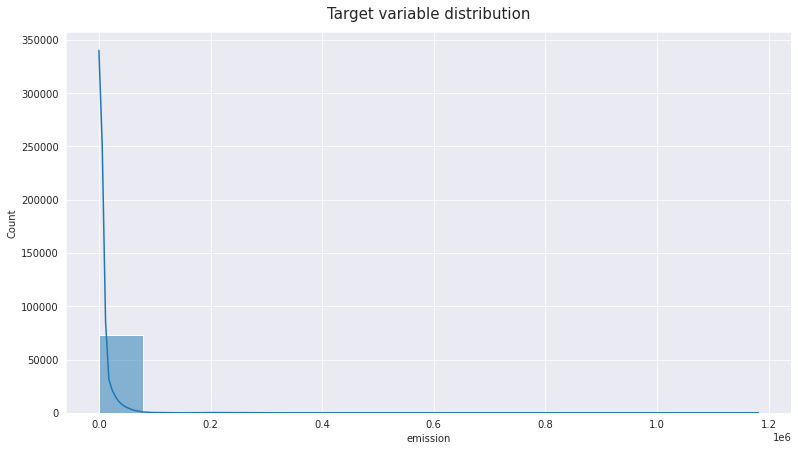

None

17.038027449698163

In [106]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

The target variable is skewed to the right with a a degree of ~17.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

<a name="Outliers"></a>
## 4. Outliers


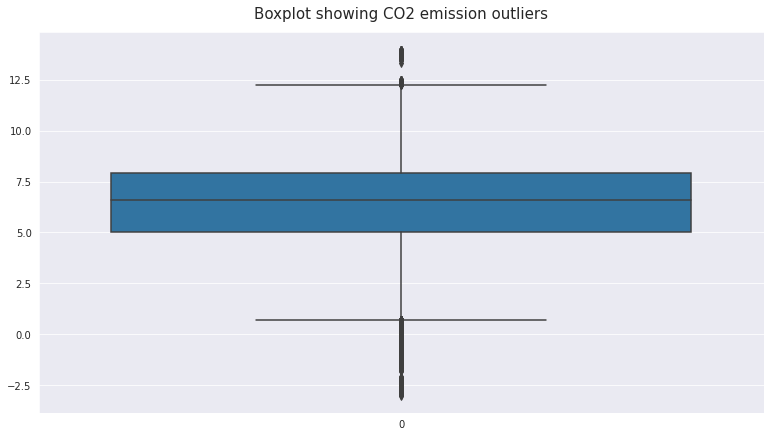

In [107]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(np.log(train.emission + 0.001))
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...
 

In [108]:
# #Transforming the emissions to a more suitable data form
# train['emission'] = np.log(train['emission'])

train = train[train['emission'] >= 1]
# calculate the interquartile range (IQR)
Q1 = train['emission'].quantile(0.25)
Q3 = train['emission'].quantile(0.75)
IQR = Q3 - Q1

# trim the data by removing outliers
train = train[(train['emission'] >= Q1 - 1.5 * IQR) & (train['emission'] <= Q3 + 1.5 * IQR)]

# drop the rows that contain the outliers
train = train.drop(train.index.difference(train.index))

In [109]:
print(train.shape)

(60498, 76)


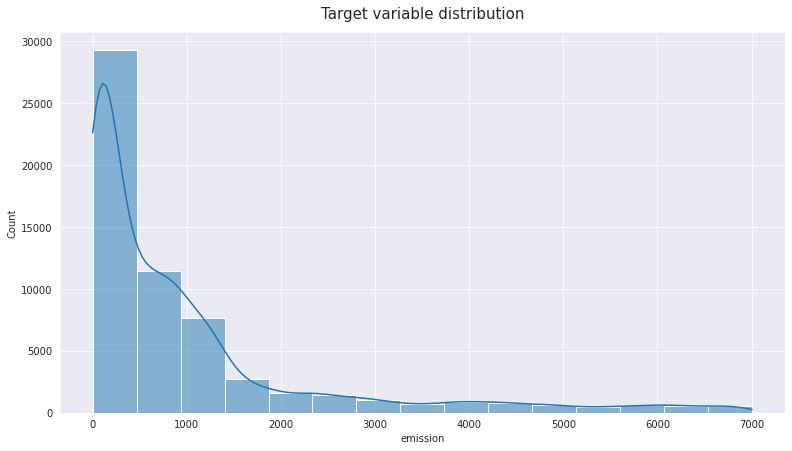

None

2.2364324021104554

In [110]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

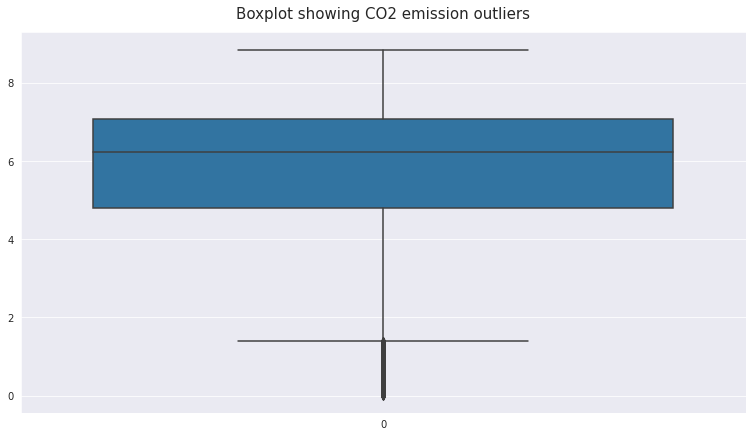

In [111]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(np.log(train.emission + 0.001))
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [112]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
1,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
2,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
3,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
4,-23.73000,28.97000,train,POINT (28.97000 -23.73000)


<a name="Missing"></a>
## 6. Missing values and duplicates

In [113]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

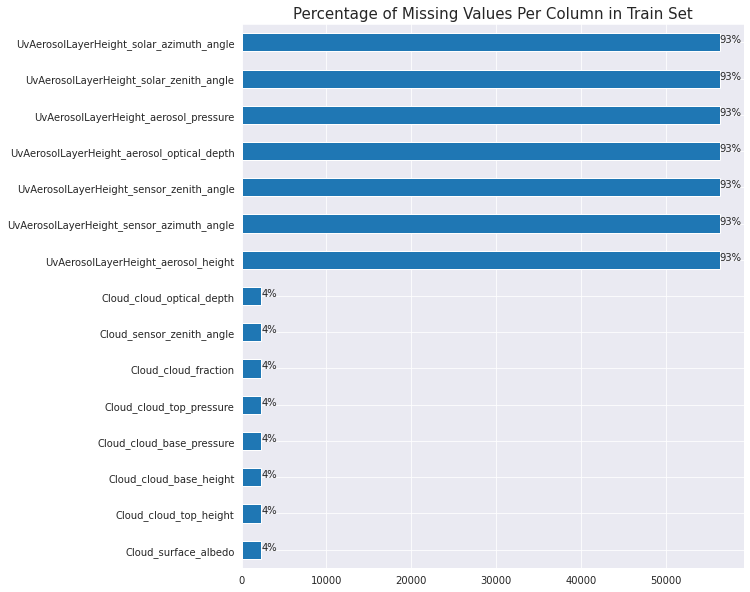

In [114]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [115]:
#Imputing the missing data
datafr = train.copy()
# Drop the columns with missing values
data_no_missing = train.drop('ID_LAT_LON_YEAR_WEEK', axis=1)

# Fit the imputer
imputer = SimpleImputer()
imputer.fit(data_no_missing)

# Impute the missing values
imputed_data = imputer.transform(data_no_missing)

# Convert back to DataFrame
train = pd.DataFrame(imputed_data, columns=data_no_missing.columns)


train['ID_LAT_LON_YEAR_WEEK'] = datafr['ID_LAT_LON_YEAR_WEEK']

# View the result
print(train.shape)


(60498, 76)


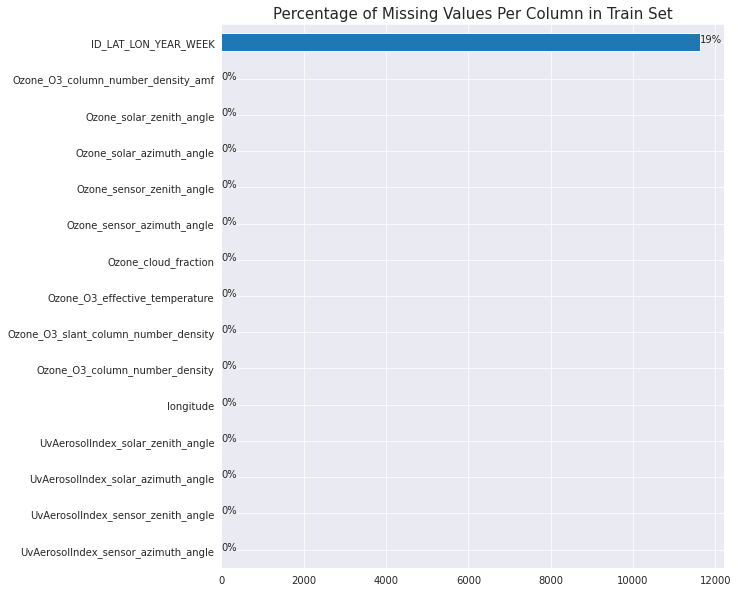

In [116]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [117]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Dates"></a>
## 7. Date features EDA

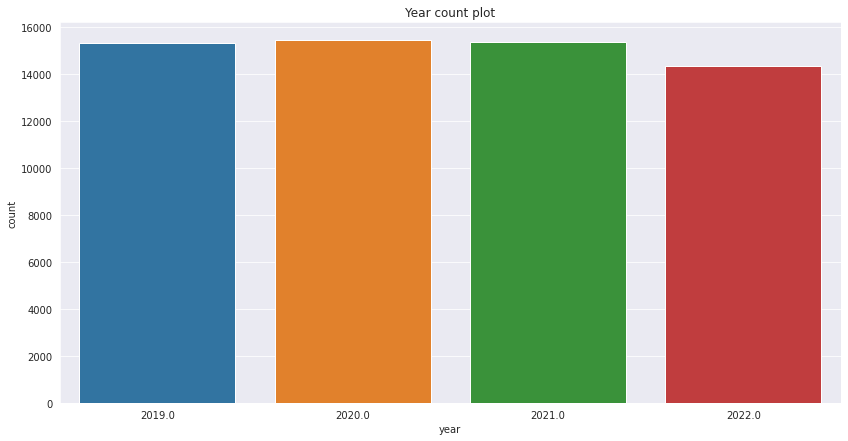

In [118]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

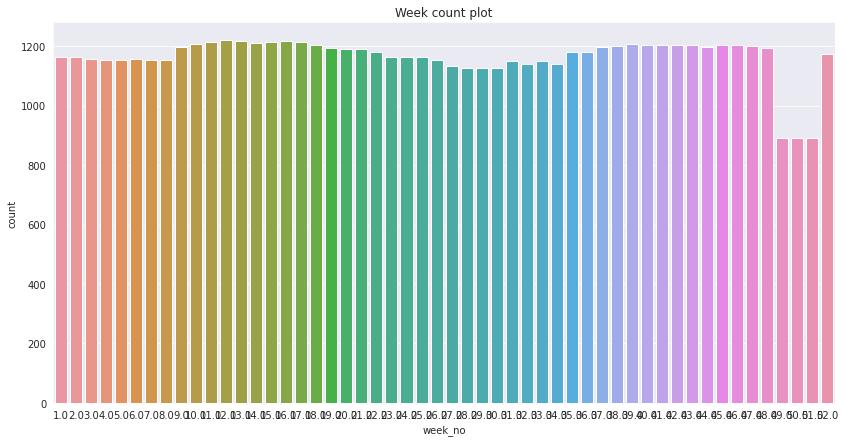

In [119]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

In [120]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019.00000,52
2020.00000,52
2021.00000,52
2022.00000,49


- The year 2022 has only 49 weeks available in the data

<a name="Correlations"></a>
## 8. Correlations - EDA

In [121]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                 1.00000
longitude                                                0.19070
NitrogenDioxide_tropospheric_NO2_column_number_density   0.10697
NitrogenDioxide_NO2_column_number_density                0.10601
CarbonMonoxide_sensor_altitude                           0.10145
UvAerosolIndex_sensor_altitude                           0.10104
NitrogenDioxide_NO2_slant_column_number_density          0.09851
NitrogenDioxide_sensor_altitude                          0.09558
latitude                                                 0.09500
SulphurDioxide_SO2_column_number_density_amf             0.08279
Ozone_O3_slant_column_number_density                     0.05501
NitrogenDioxide_tropopause_pressure                      0.05430
Cloud_cloud_base_pressure                                0.04866
Ozone_cloud_fraction                                     0.04522
SulphurDioxide_SO2_column_number_density                 0.04520
Ozone_O3_column_number_de

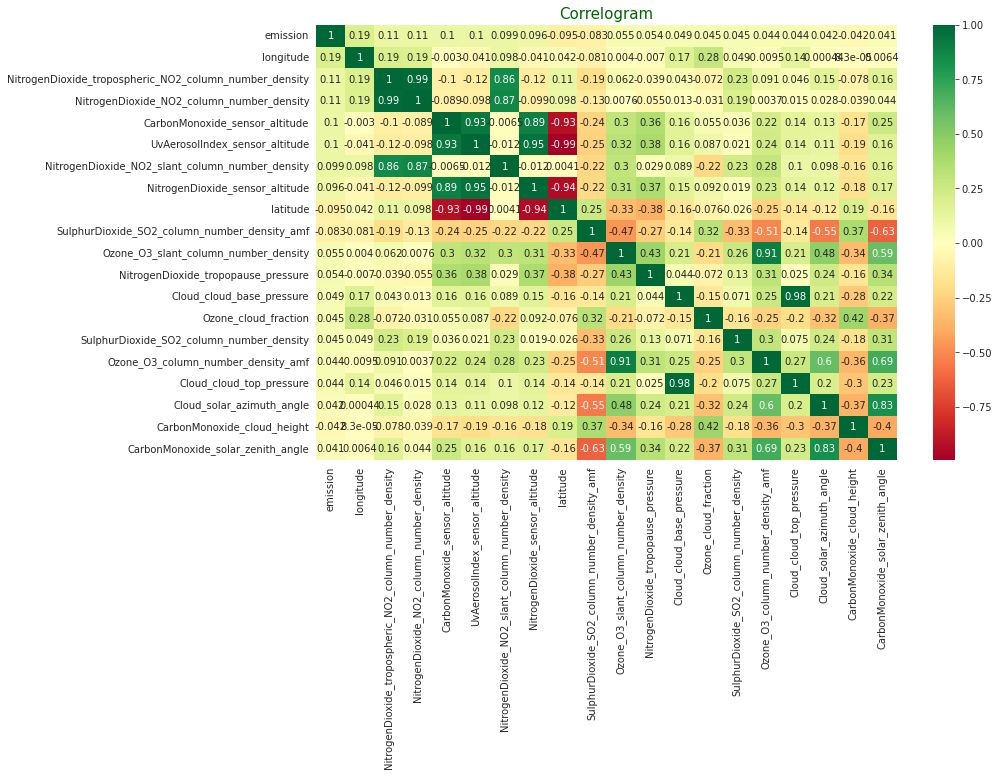

In [122]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

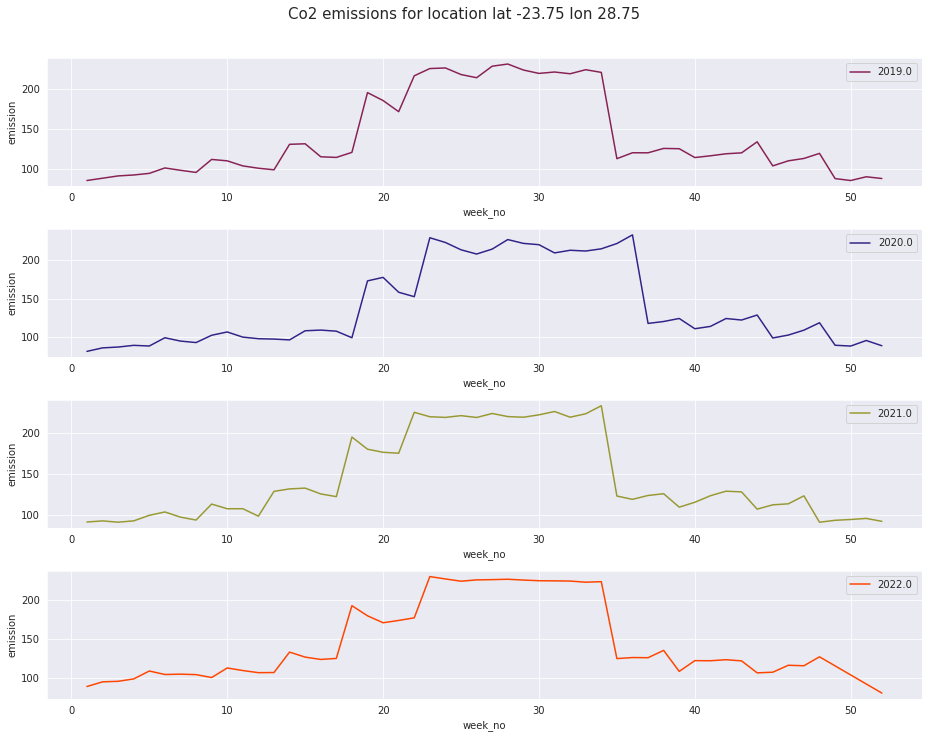

In [123]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering









0    -23.73_28.77
1    -23.73_28.77
2    -23.73_28.77
3    -23.73_28.77
4    -23.73_28.77
Name: location, dtype: object


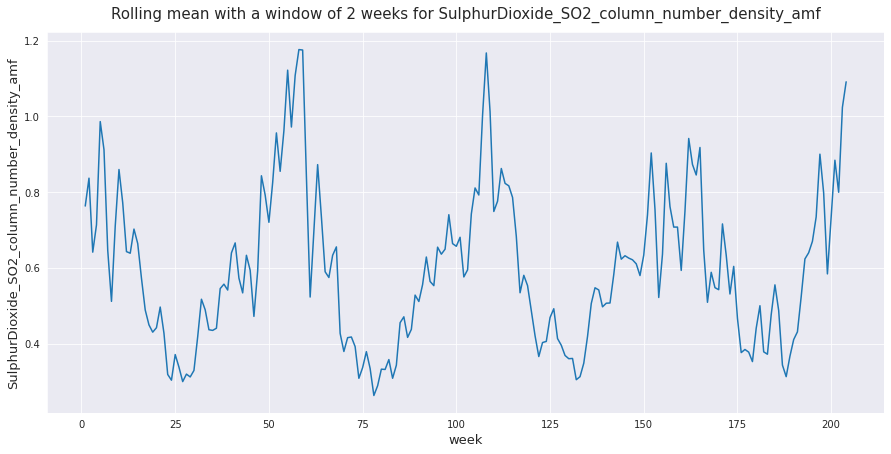

In [124]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]
print(train["location"].head())
# Filter based on one location
example_loc = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

In [125]:
print(train.shape)

(60498, 77)


In [126]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00013,0.43882,0.00005,0.09470,-49.02600,55.93510,-92.36411,26.77170,0.00002,0.02549,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,0.00012,0.56813,0.00005,0.09466,-0.52002,44.99212,-88.07020,21.95860,0.00002,0.02503,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,0.00027,0.57377,0.00011,0.12280,-2.87484,47.10618,-82.84357,22.25336,0.00004,0.02369,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,0.00034,0.60875,0.00016,0.14627,-8.86249,49.32330,-77.79334,22.96216,0.00007,0.02297,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


In [127]:
print(train.shape)

(60498, 77)


In [128]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


In [129]:
print(train.shape)
print(train_eng.shape)
print(test_eng.shape)

(60498, 77)
(60498, 146)
(28085, 146)


In [130]:
train_eng.describe(include = 'all')

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
count,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,...,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-27.81740,27.73134,2020.47468,26.20282,0.00025,0.52168,0.00009,0.10452,4.17866,45.35466,...,68170.15283,3631.99010,74554.77165,2854.38642,16.00163,0.22768,-14.86814,49.48641,-50.56253,40.59088
std,2.81682,2.82885,1.10949,14.86164,0.00058,0.19512,0.00019,0.06847,51.47394,14.56674,...,10504.90830,1412.80775,9990.78619,1265.49170,15.23272,0.05905,35.20788,8.16331,19.55823,11.55469
min,-33.93000,21.07000,2019.00000,1.00000,-0.00098,0.13374,-0.00080,0.00000,-110.02766,0.09953,...,26805.61123,359.79303,30972.68129,148.79402,1.20648,0.00000,-106.26902,6.54892,-97.31427,11.68104
25%,-29.63000,26.27000,2019.00000,13.00000,-0.00006,0.38063,-0.00003,0.05265,-17.79179,33.28277,...,60921.16182,2613.90600,67872.90483,1906.65077,6.32406,0.19028,-35.48647,44.88648,-66.57894,30.57347
50%,-28.23000,28.87000,2020.00000,26.00000,0.00015,0.49961,0.00007,0.10083,-10.61954,47.06915,...,68147.75021,3556.49793,75020.02678,2722.07786,10.96477,0.22690,-14.63636,50.45317,-45.54320,40.49900
75%,-24.43000,29.47000,2021.00000,39.00000,0.00041,0.62535,0.00018,0.14920,57.92594,59.30678,...,75620.95956,4547.47790,81934.74899,3640.69537,18.99952,0.26808,1.71101,55.58636,-34.34260,50.38140


In [131]:
# Scale Data

# instantiate the scaler object
scaler = StandardScaler()

dataengfr = train_eng.copy()
data_eng = train_eng.drop(['ID_LAT_LON_YEAR_WEEK','location','emission'], axis=1)

# fit and transform the data
train_eng_data = scaler.fit_transform(data_eng)

# convert the numpy array back to a DataFrame
train_eng = pd.DataFrame(train_eng_data, columns=data_eng.columns)
print(train_eng.shape)
print(train_eng_data.shape)

(60498, 143)
(60498, 143)


In [132]:
print('ID_LAT_LON_YEAR_WEEK' in train_eng.columns)
for one in ['ID_LAT_LON_YEAR_WEEK','location','emission']:
  train_eng[one] = dataengfr[one]
print('ID_LAT_LON_YEAR_WEEK' in train_eng.columns)
print(train_eng.shape)

False
True
(60498, 146)


In [133]:
train_eng.describe(include = 'all')

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean,ID_LAT_LON_YEAR_WEEK,location,emission
count,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,60498.00000,...,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,60185.00000,48874,60498,60498.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48874,313,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_-23.73_28.77_2019_1,-23.73_28.77,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,205,NaN
mean,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,...,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,NaN,NaN,1020.63362
std,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,...,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,NaN,NaN,1428.18448
min,-2.17005,-2.35481,-1.32916,-1.69584,-2.13086,-1.98822,-4.54763,-1.52651,-2.21874,-3.10677,...,-2.13799,-0.97128,-3.85560,-2.59606,-5.25986,-2.39041,-2.50202,NaN,NaN,1.00112
25%,-0.64350,-0.51659,-1.32916,-0.88839,-0.54151,-0.72287,-0.61842,-0.75749,-0.42683,-0.82874,...,-0.74891,-0.63532,-0.63326,-0.58562,-0.56349,-0.81892,-0.86696,NaN,NaN,122.03755
50%,-0.14648,0.40252,-0.42784,-0.01365,-0.17336,-0.11308,-0.06578,-0.05382,-0.28749,0.11770,...,-0.10455,-0.33066,-0.01309,0.00658,0.11843,0.25664,-0.00795,NaN,NaN,506.99897
75%,1.20257,0.61462,0.47349,0.86110,0.28328,0.53134,0.48991,0.65265,1.04417,0.95781,...,0.62135,0.19681,0.68421,0.47090,0.74725,0.82932,0.84733,NaN,NaN,1191.06250


In [138]:
# Transforming the tesing data

testengfr = test_eng.copy()
data_test_eng = test_eng.drop(['ID_LAT_LON_YEAR_WEEK','location','SulphurDioxide_SO2_column_number_density_roll_mean'], axis=1)
# data_test_eng = data_test_eng[train_eng.columns[:-1]]

# fit and transform the data
test_eng_data = scaler.transform(data_test_eng)

# convert the numpy array back to a DataFrame
test_eng = pd.DataFrame(test_eng_data, columns=data_test_eng.columns)

In [141]:
print(test_eng.shape)
print('ID_LAT_LON_YEAR_WEEK' in test_eng.columns)
for one in ['ID_LAT_LON_YEAR_WEEK','location','SulphurDioxide_SO2_column_number_density_roll_mean']:
  test_eng[one] = testengfr[one]
print('ID_LAT_LON_YEAR_WEEK' in test_eng.columns)
print(test_eng.shape)

(28085, 146)
True
True
(28085, 146)


<a name="Modelling"></a>
## 11.  Modelling

In [142]:
test_eng = test_eng.drop('SulphurDioxide_SO2_column_number_density_roll_mean', axis=1)

In [143]:
print('SulphurDioxide_SO2_column_number_density_roll_mean' in test_eng.columns)

False


In [144]:
# Selecting the independent variables and the target variable

X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = XGBRegressor(random_state=SEED, n_estimators=100, max_depth=10, learning_rate=0.1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

RMSE Score: 230.6364980705977


In [145]:
X_test.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
38900,-0.53699,0.93278,0.47349,-1.29212,-1.06495,-0.73040,-1.13265,-0.55744,-2.09664,0.13323,...,0.68645,-0.68748,0.64286,-0.67784,-0.29696,1.66451,-0.05120,-0.22977,-0.19826,-1.08257
44907,-0.64350,1.03883,0.47349,-1.29212,-0.54646,-0.43876,-0.55102,-1.14939,-2.09742,-0.12627,...,0.71744,-0.73727,1.04362,-0.99773,-0.55807,1.42511,1.20446,0.19835,0.12129,-1.30630
48778,-0.75000,0.96813,0.47349,0.18822,2.29544,-1.19111,1.90661,-1.16851,1.21845,0.84163,...,0.25275,-0.50134,0.56685,-0.73106,-0.41570,-0.11215,-0.02911,-0.35184,1.29027,1.31958
13029,1.23807,0.61462,-1.32916,1.66855,-0.90817,0.28778,-1.27886,-0.78074,-0.34333,-1.31570,...,-1.16069,1.37992,-1.37599,1.54896,2.81782,0.71896,-0.63101,-0.11103,-2.19086,-1.19126
30909,-0.14648,-2.24876,0.47349,1.53397,0.13586,0.94656,0.71952,0.37695,-0.34561,1.10135,...,-0.87644,0.85320,-0.81445,0.78665,0.18189,-0.17101,0.03860,-3.06778,-1.72667,-1.17664


In [146]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[['latitude',	'longitude',	'year',	'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

,latitude,longitude,year,week_no,emission,prediction,error
8056,1.30907,0.43787,-0.42784,-0.61924,6821.30030,1857.40833,4963.89197
8058,1.30907,0.43787,1.37481,1.73584,6917.53120,2113.52783,4804.00337
18846,0.63455,0.01367,-0.42784,-0.61924,6748.04000,2026.44299,4721.59701
8057,1.30907,0.43787,-0.42784,-0.55195,6708.04300,2255.42993,4452.61307
59058,-1.81504,0.08437,-1.32916,0.59194,6758.80600,3917.87109,2840.93491


In [147]:
pred_errors.tail()

,latitude,longitude,year,week_no,emission,prediction,error
27241,-0.07548,-2.31946,1.37481,-0.28280,61.08206,61.04439,0.03767
21413,0.35054,-1.08219,0.47349,-0.82110,191.93527,191.90260,0.03267
30559,-0.14648,-2.31946,1.37481,-0.95568,85.05415,85.08007,0.02592
27378,-0.07548,-2.28411,0.47349,1.66855,1.07811,1.05508,0.02303
19097,0.63455,0.57927,-1.32916,1.26482,568.53204,568.51660,0.01544


In [148]:
train.emission.describe()

count   60498.00000
mean     1020.63362
std      1428.18448
min         1.00112
25%       122.03755
50%       506.99897
75%      1191.06250
max      7006.14160
Name: emission, dtype: float64

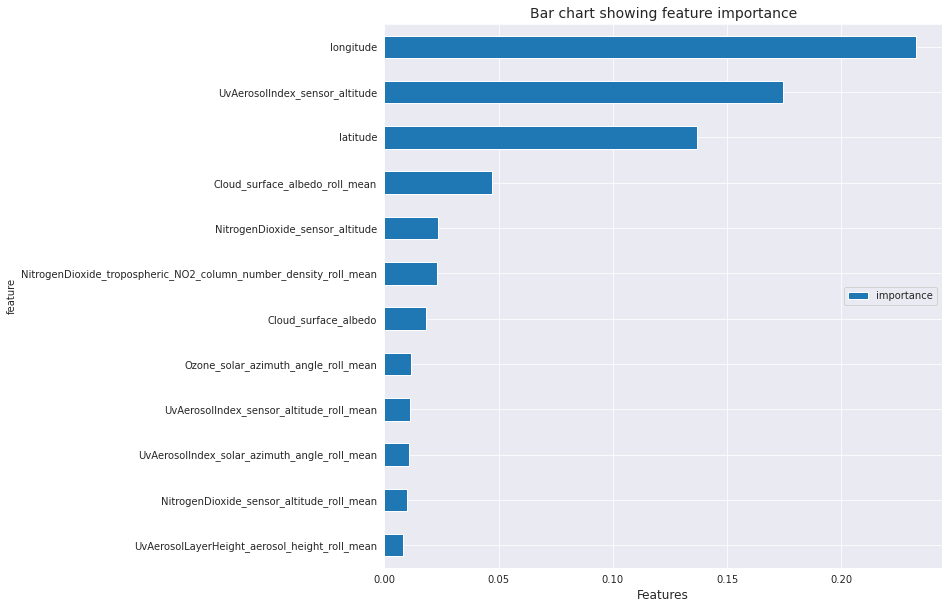

In [149]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [150]:
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
print(test_df.shape)
print(train_eng.shape)

(28085, 143)
(60498, 146)


<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [151]:
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
# print(train.columns)
# print('----------------------------------------------------------------------------------------------------------------------')
# print(test_df.columns)

diff1 = set(train_eng.columns) - set(test_df.columns)
print('Elements in Train but not in test : ',diff1)
diff2 = set(test_df.columns) - set(train_eng.columns)
print('Elements in Test but not in Train : ',diff2)

Elements in Train but not in test :  {'ID_LAT_LON_YEAR_WEEK', 'location', 'emission'}
Elements in Test but not in Train :  set()


In [152]:
# Make prediction on the test set
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = clf.predict(test_df)

# trans_preds = np.exp(predictions)
# Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file
sub_file.head()

#lmbda= 0.057450389972568995

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,1221.49805
1,ID_-23.53_27.47_2019_2,1187.04346
2,ID_-23.53_27.47_2019_3,1292.88440
3,ID_-23.53_27.47_2019_4,1494.71631
4,ID_-23.53_27.47_2019_5,1397.09033


In [154]:
# Create file
sub_file.to_csv('Submission_v9.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;